# OASIS AS_REQ DAM
OASIS AS_REQ Day Ahead Market Report(s)

## Load the data

In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf

# Create the connection
cnx = sqlite3.connect(r'../data/data-oasis-as-req-dam/db/caiso-oasis-as-req-dam.db')

## Preview the schema

In [8]:
for row in cnx.execute("PRAGMA table_info([oasis]);"):
    print(row)

(0, 'timedate', 'STRING', 0, None, 0)
(1, 'timedate_posix', 'INTEGER', 0, None, 0)
(2, 'source', 'STRING', 0, None, 1)
(3, 'version', 'STRING', 0, None, 0)
(4, 'name', 'STRING', 0, None, 2)
(5, 'system', 'STRING', 0, None, 3)
(6, 'tz', 'STRING', 0, None, 4)
(7, 'report', 'STRING', 0, None, 5)
(8, 'mkt_type', 'STRING', 0, None, 6)
(9, 'uom', 'STRING', 0, None, 7)
(10, 'interval', 'STRING', 0, None, 0)
(11, 'sec_per_interval', 'INTEGER', 0, None, 0)
(12, 'data_item', 'STRING', 0, None, 8)
(13, 'resource_name', 'STRING', 0, None, 9)
(14, 'opr_date', 'STRING', 0, None, 0)
(15, 'opr_date_8601', 'STRING', 0, None, 0)
(16, 'interval_num', 'INTEGER', 0, None, 10)
(17, 'interval_start_gmt', 'STRING', 0, None, 0)
(18, 'interval_start_posix', 'INTEGER', 0, None, 11)
(19, 'interval_end_gmt', 'STRING', 0, None, 0)
(20, 'interval_end_posix', 'INTEGER', 0, None, 12)
(21, 'value', 'NUMBER', 0, None, 0)


## Preview the available reports

In [9]:
for row in cnx.execute("select distinct report from oasis"):
    print(row)

('AS_REQ',)


## Preview the data_item(s) in the 'AS_REQ' report

In [10]:
for row in cnx.execute("select distinct data_item from oasis where report == 'AS_REQ';"):
    print(row)

('NS_REQ_MAX_MW',)
('NS_REQ_MIN_MW',)
('RD_REQ_MAX_MW',)
('RD_REQ_MIN_MW',)
('RMD_REQ_MAX_MW',)
('RMD_REQ_MIN_MW',)
('RMU_REQ_MAX_MW',)
('RMU_REQ_MIN_MW',)
('RU_REQ_MAX_MW',)
('RU_REQ_MIN_MW',)
('SP_REQ_MAX_MW',)
('SP_REQ_MIN_MW',)


## Sample the data

In [11]:
for row in cnx.execute("select data_item, value, interval_start_gmt  from oasis where report == 'AS_REQ' limit 10;"):
    print(row)

('NS_REQ_MAX_MW', 0, '2013-01-01T07:00:00-00:00')
('NS_REQ_MIN_MW', 486.73, '2013-01-01T07:00:00-00:00')
('RD_REQ_MAX_MW', 0, '2013-01-01T07:00:00-00:00')
('RD_REQ_MIN_MW', 10, '2013-01-01T07:00:00-00:00')
('RU_REQ_MAX_MW', 0, '2013-01-01T07:00:00-00:00')
('RU_REQ_MIN_MW', 10, '2013-01-01T07:00:00-00:00')
('SP_REQ_MAX_MW', 0, '2013-01-01T07:00:00-00:00')
('SP_REQ_MIN_MW', 486.73, '2013-01-01T07:00:00-00:00')
('NS_REQ_MAX_MW', 0, '2013-01-01T07:00:00-00:00')
('NS_REQ_MIN_MW', 811.21, '2013-01-01T07:00:00-00:00')


## Load a dataframe

In [12]:
df = pd.read_sql("select data_item, value, interval_start_posix from oasis where report = 'AS_REQ';", cnx)
df[0:5]

,data_item,value,interval_start_posix
0,NS_REQ_MAX_MW,0.00,1357023600
1,NS_REQ_MIN_MW,486.73,1357023600
2,RD_REQ_MAX_MW,0.00,1357023600
3,RD_REQ_MIN_MW,10.00,1357023600
4,RU_REQ_MAX_MW,0.00,1357023600


## Spin up a report for each data_item

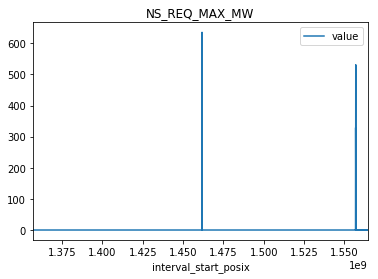

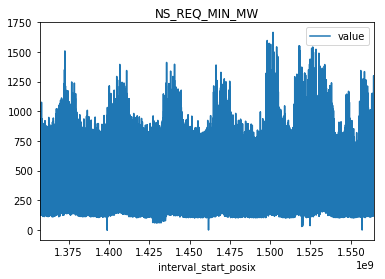

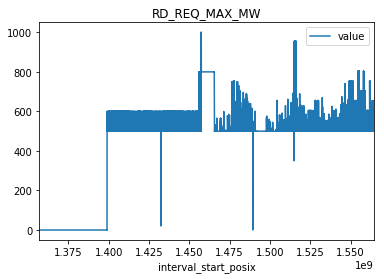

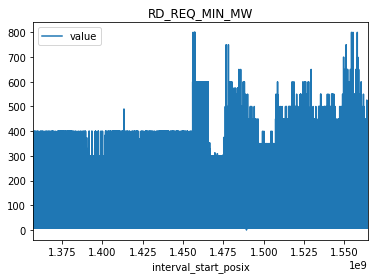

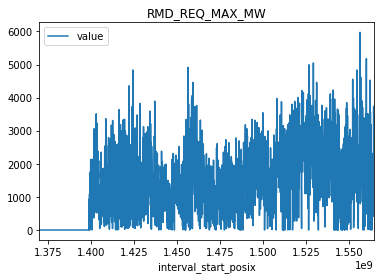

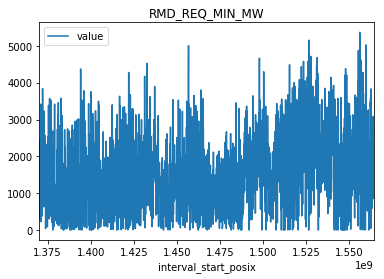

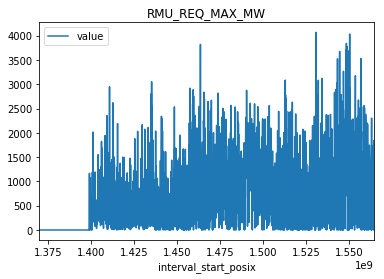

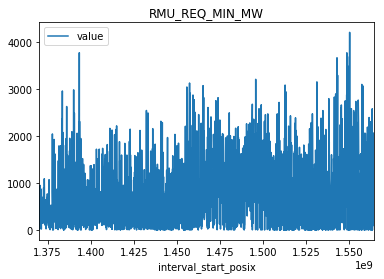

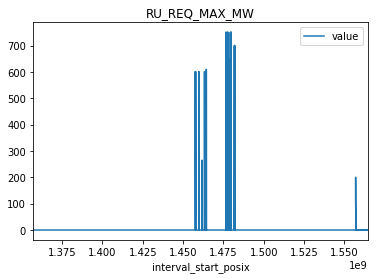

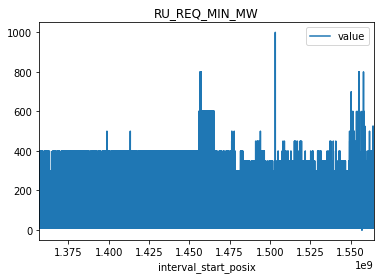

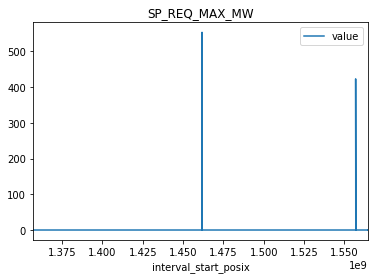

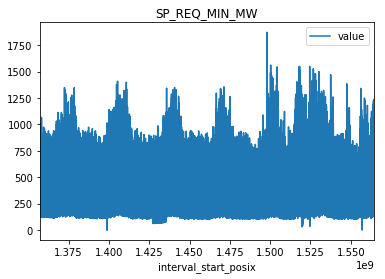

In [13]:
for title, group in df.groupby('data_item'):
    group.plot.line(x='interval_start_posix', y='value', title=title)

### TODO
* Label each axis
* Replace the x axis (posix) with an actual date (year)
* Fix data issues (get missing data)
* Provide some sort of meaningful analysis / text to go with this

### NOTES

To be clear, this is just the initial POC notebook.